In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('../raw_data.csv')
df.head()

,startCarNumber,totalCarNumber,overhead,duration
0,448,450,3.168827,399
1,449,450,3.214583,385
2,449,450,2.196230,374
3,448,450,2.765115,396
4,447,450,1.106537,254


In [3]:
df.describe()

,startCarNumber,totalCarNumber,overhead,duration
count,190718.000000,190718.000000,190718.000000,1.907180e+05
mean,456.969054,470.406988,2.565932,7.421084e+02
std,148.338356,156.462564,3.816828,1.469557e+04
min,46.000000,50.000000,0.713012,2.000000e+00
25%,348.000000,350.000000,1.358919,1.760000e+02
50%,497.000000,500.000000,1.737254,3.020000e+02
75%,547.000000,600.000000,2.256226,4.660000e+02
max,716.000000,720.000000,30.000000,1.021038e+06


In [4]:
df_before = df.iloc[:108154, :].reset_index()
df_after = df.iloc[108154: , :].reset_index()

In [5]:
df_before.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,108154.000000,108154.000000,108154.000000,108154.000000,108154.000000
mean,54076.500000,453.564870,458.521090,1.908776,408.830066
std,31221.514844,145.230969,147.398434,1.115591,4799.744546
min,0.000000,46.000000,50.000000,0.792285,2.000000
25%,27038.250000,349.000000,350.000000,1.354698,173.000000
50%,54076.500000,497.000000,500.000000,1.709612,295.000000
75%,81114.750000,546.000000,550.000000,2.156942,446.000000
max,108153.000000,619.000000,620.000000,30.000000,330973.000000


In [6]:
df_after.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,82564.00000,82564.000000,82564.000000,82564.000000,8.256400e+04
mean,149435.50000,461.428334,485.976818,3.426767,1.178683e+03
std,23834.31815,152.198701,166.316692,5.542095,2.164125e+04
min,108154.00000,47.000000,50.000000,0.713012,3.000000e+00
25%,128794.75000,348.000000,350.000000,1.365618,1.800000e+02
50%,149435.50000,496.000000,500.000000,1.781210,3.110000e+02
75%,170076.25000,588.000000,600.000000,2.444259,4.980000e+02
max,190717.00000,716.000000,720.000000,30.000000,1.021038e+06


In [7]:
df_before = df
df_before['c'] = df_before['totalCarNumber'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

47


[0, 8504, 17871, 28129, 35393, 39347, 40113, 43207, 44010, 46507, 55188, 64540, 74400, 83050, 89007, 92511, 101554, 110667, 121308, 131701, 138780, 143300, 144507, 153786, 156177, 158731, 161139, 163005, 164049, 164212, 165244, 165470, 166115, 168320, 170793, 173093, 174973, 176167, 177196, 179716, 181980, 185079, 185392, 187137, 188174, 188424, 190438]


47

In [8]:
one = list_of_dfs[1]

In [9]:
one['duration']

8504     166
8505     507
8506     367
8507     180
8508     575
        ... 
17866    202
17867    195
17868    475
17869     51
17870    156
Name: duration, Length: 9367, dtype: int64

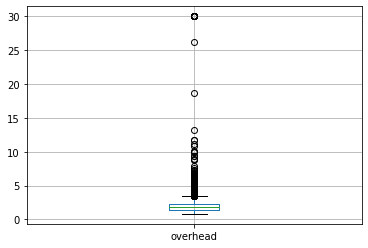

In [10]:
boxplot = one.boxplot(column=['overhead'])

In [11]:
one.describe()

,startCarNumber,totalCarNumber,overhead,duration,c
count,9367.000000,9367.0,9367.000000,9367.000000,9367.000000
mean,514.699477,520.0,1.970991,364.785417,0.007473
std,7.566483,0.0,1.275366,995.890892,0.723266
min,442.000000,520.0,0.814174,3.000000,0.000000
25%,514.000000,520.0,1.377852,177.000000,0.000000
50%,516.000000,520.0,1.770357,302.000000,0.000000
75%,517.000000,520.0,2.232731,462.000000,0.000000
max,519.000000,520.0,30.000000,30481.000000,70.000000


In [12]:
duration_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    duration_df = pd.concat([duration_df,i['duration'].reset_index()['duration']], ignore_index=True, axis=1)
    counter += 1

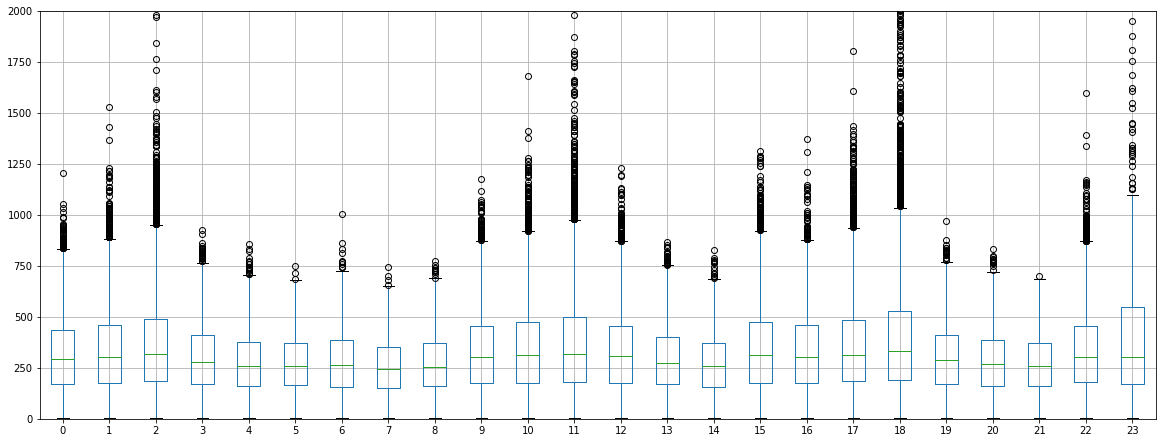

In [13]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

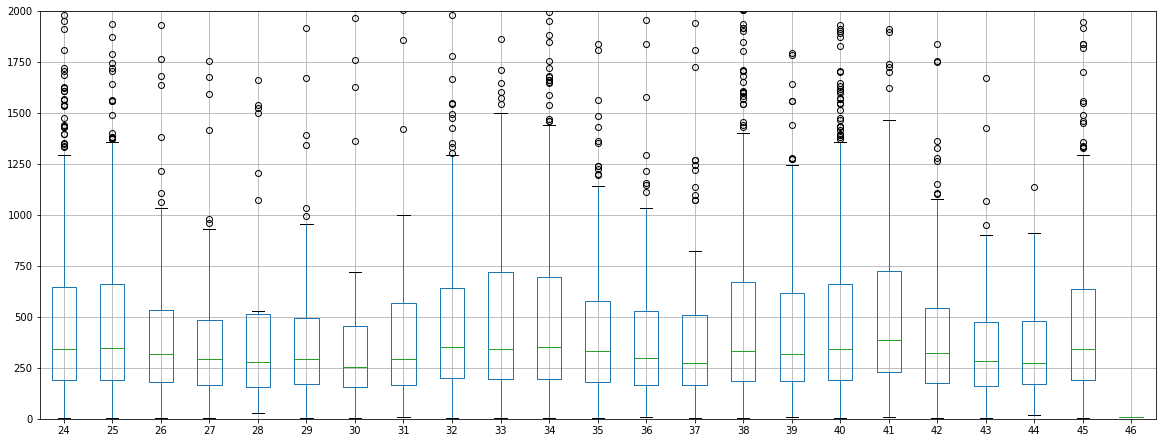

In [14]:
columns = list(range(24, 47))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

In [15]:
overhead_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    overhead_df = pd.concat([overhead_df,i['overhead'].reset_index()['overhead']], ignore_index=True, axis=1)
    counter += 1

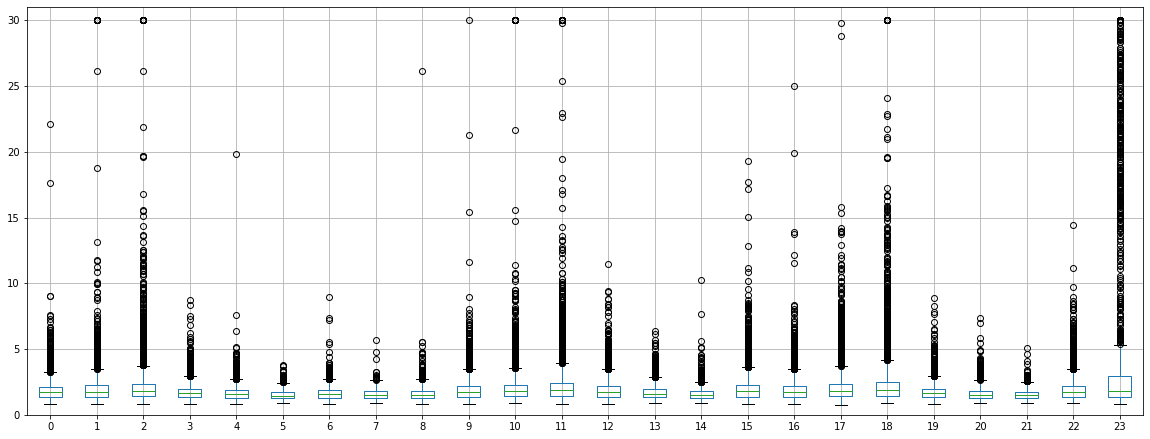

In [16]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

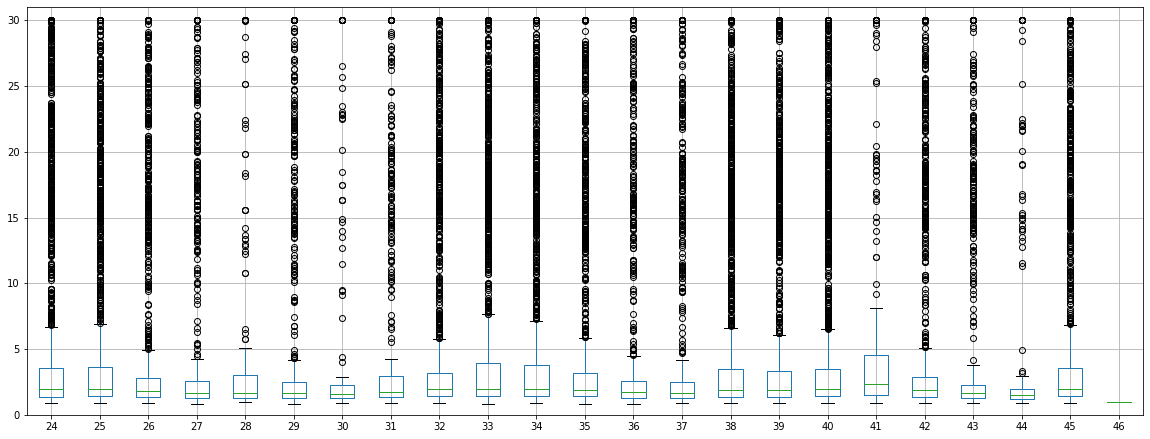

In [17]:
columns = list(range(24, 47))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

In [18]:
df_data = pd.read_csv('../data.csv')
df_data.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,1044,1.679310,1.346303,2.075748,2.517579
1,1,450,1502,1.745447,1.389847,2.203232,2.755298
2,2,450,1492,1.722527,1.337932,2.170672,2.719500
3,3,450,1512,1.706235,1.350705,2.131536,2.705816
4,4,450,1481,1.671983,1.333558,2.063440,2.520975


In [19]:
df_data = df_data.iloc[::6, :].reset_index()
df_data = df_data.drop(columns=['index', 'level_0'])
df_data.head(10)

# ax = df_data.plot.bar( y='numberOfTrips', rot=90, figsize=(20,7.5))

,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,450,1044,1.679310,1.346303,2.075748,2.517579
1,520,1537,1.790427,1.353740,2.257434,2.850351
2,600,1681,1.803263,1.394887,2.391850,3.256516
3,350,1220,1.649503,1.338586,2.026009,2.469207
4,200,695,1.530378,1.270904,1.870320,2.194752
5,50,132,1.462074,1.265938,1.773137,2.071857
6,200,517,1.589455,1.322550,1.898747,2.297491
7,50,130,1.508644,1.246438,1.825906,1.983434
8,150,435,1.537595,1.282965,1.833407,2.191073
9,500,1498,1.723630,1.363938,2.184269,2.790772


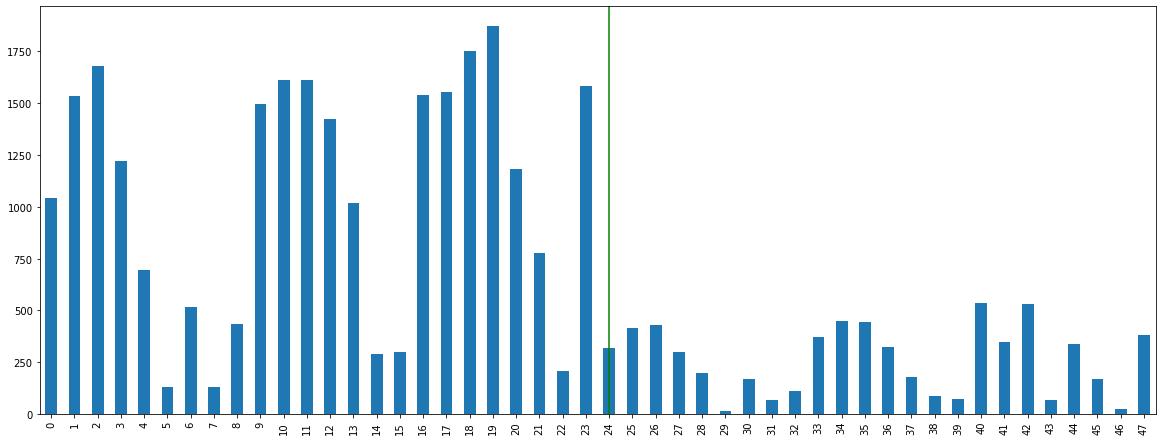

In [20]:
fig, ax = plt.subplots(figsize=(20,7.5))
ax = df_data.plot.bar(y='numberOfTrips', rot=90, ax=ax, legend=None)
ax.axvline(x=24, c='g')